In [88]:
import os
import re
import glob
import shutil
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import rasterio
from rasterio.windows import Window



In [98]:
def preprocess_and_save_images(base_dataset_path):

    folders = os.listdir(base_dataset_path)
    files = []
    for folder in tqdm(folders, desc="Processing folders", ncols=100):
        img_data_path = os.path.join(base_dataset_path, folder, "*.SAFE/GRANULE/*/IMG_DATA/*_TCI.jp2")
        tci_image_files = glob.glob(img_data_path)

        if not tci_image_files:
            continue

        # tqdm for images inside each folder
        for image_file in tci_image_files:
            # print(image_file)
            files.append(image_file)

    return files


In [99]:
base_dataset_path = '/kaggle/input/deforestation-in-ukraine/'
files = preprocess_and_save_images(base_dataset_path)
print(f"Num images: {len(files)}")

Processing folders: 100%|██████████████████████████████████████████| 51/51 [00:00<00:00, 143.31it/s]

Num images: 50


# Extracting images

Now we will detect and extract the first area that contains meaningful visual information instead of black or empty regions. It then saves this part as a processed image for further analysis. Since feature matching relies on visible details, images with large black areas are considered invalid or possibly captured with errors and are excluded. 

Instead of taking the entire large image and compressing it into a JPG, only specific 1024×1024 fragments are selected for processing.


In [100]:
def find_nonblack_subset(input_path, width=1024, height=1024, step=512, min_nonzero_ratio=0.2):
    """
    Finds the first non-black subset in a JP2 image and checks if it starts
    away from the top-left corner (x=0, y=0).

    min_nonzero_ratio: Minimum ratio of nonzero pixels to accept.

    """
    
    with rasterio.open(input_path) as src:
        full_width, full_height = src.width, src.height

        for y in range(0, full_height - height, step):
            for x in range(0, full_width - width, step):
                window = Window(col_off=x, row_off=y, width=width, height=height)
                patch = src.read(window=window)
                patch = np.transpose(patch, (1, 2, 0))

                nonzero_ratio = np.count_nonzero(patch) / patch.size

                if nonzero_ratio > min_nonzero_ratio:
                    if x != 0 or y != 0:
                        print(f"Non-black area found in {os.path.basename(input_path)}")
                        print(f"Location: x={x}, y={y}, nonzero_ratio={nonzero_ratio:.2f}\n")
                    return patch, (x, y), nonzero_ratio

    return None


def save_subset_as_png(subset, input_path, output_dir="subsets", show=False):
    
    os.makedirs(output_dir, exist_ok=True)

    subset = subset.astype(float)
    subset /= np.percentile(subset, 99)
    subset = np.clip(subset, 0, 1)
    subset = (subset * 255).astype(np.uint8)

    base_name = os.path.splitext(os.path.basename(input_path))[0]
    output_path = os.path.join(output_dir, f"{base_name}.png")
    Image.fromarray(subset).save(output_path)
    
    if show:
        plt.figure(figsize=(8, 8))
        plt.imshow(subset)
        plt.title(f"Subset from {base_name}")
        plt.axis("off")
        plt.show()

    return output_path



Non-black area found in T36UYA_20160509T082612_TCI.jp2
Location: x=6144, y=0, nonzero_ratio=0.29



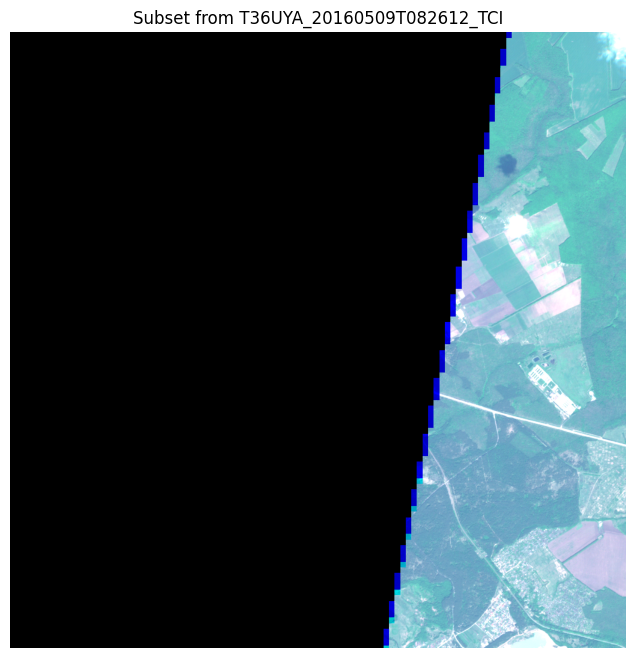

Non-black area found in T36UYA_20160330T082542_TCI.jp2
Location: x=6656, y=0, nonzero_ratio=0.64



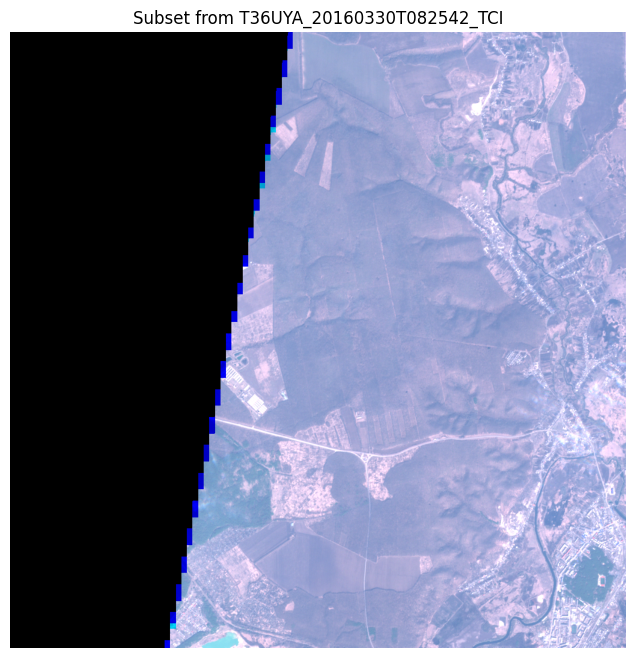

Non-black area found in T36UYA_20160618T082602_TCI.jp2
Location: x=6656, y=0, nonzero_ratio=0.66



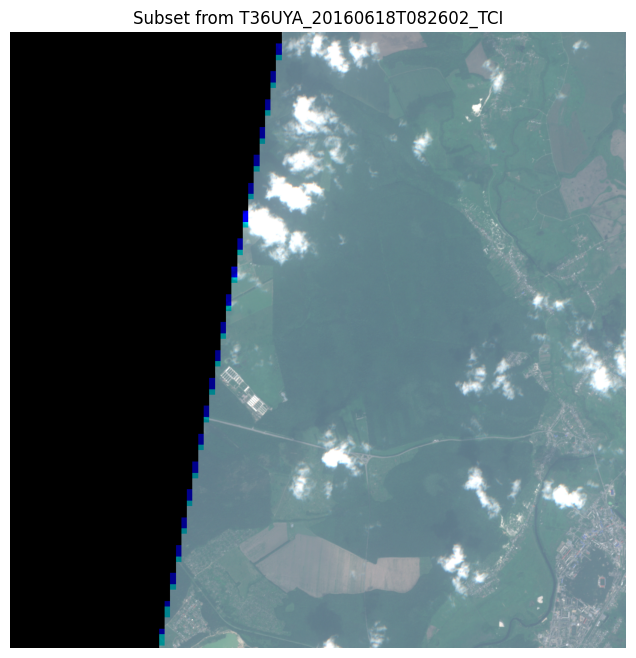

Non-black area found in T36UYA_20161026T083032_TCI.jp2
Location: x=6656, y=0, nonzero_ratio=0.67



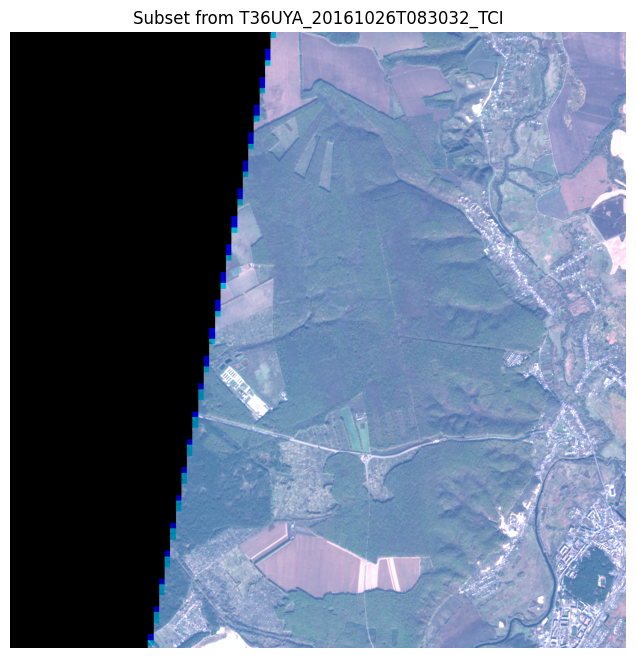

Non-black area found in T36UYA_20161205T083332_TCI.jp2
Location: x=6144, y=0, nonzero_ratio=0.32



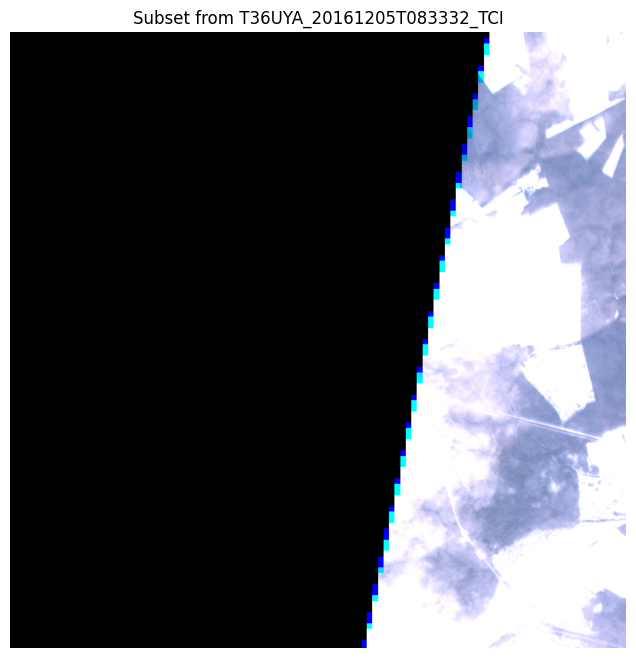

In [101]:
not_save = []
for i in files:
   name = i.split("/")[-1:][0]
   result = find_nonblack_subset(i, min_nonzero_ratio=0.2)
   if result:
       subset, coords, nonzero_ratio = result
       if nonzero_ratio < 0.7:
           save_subset_as_png(subset, i, output_dir="subsets", show=True)
           not_save.append(name.replace("jp2", "png"))
       else:
           save_subset_as_png(subset, i, output_dir="subsets", show=False)

    


# Saving

Since the images were taken over several years, it is better to store them in separate folders by year for easier organization and analysis. Additionally, we will not save the images displayed in the previous step to avoid duplicates and save storage space.


In [102]:
def organize_images_by_year(
    input_dir="/kaggle/working/output_subsets",
    output_dir="/kaggle/working/sorted_by_year",
    not_save=None
):
    
    if not_save is None:
        not_save = []

    not_save_basenames = {os.path.basename(p) for p in not_save}
    os.makedirs(output_dir, exist_ok=True)

    files = [
        f for f in os.listdir(input_dir)
        if f.lower().endswith(('.png', '.jpg', '.jpeg'))
    ]

    if not files:
        print("No image files found.")
        return

    for f in files:
        if f in not_save_basenames:
            print(f"Skipped {f} (in not_save list)")
            continue

        match = re.search(r"T36U[A-Z]{2}_(\d{4})", f)
        if not match:
            print(f"Could not extract year from {f}")
            continue

        year = match.group(1)
        year_dir = os.path.join(output_dir, year)
        os.makedirs(year_dir, exist_ok=True)

        src_path = os.path.join(input_dir, f)
        dst_path = os.path.join(year_dir, f)
        shutil.copy2(src_path, dst_path)


    print(f"Done. All files organized in {output_dir}")

organize_images_by_year(
    "/kaggle/working/subsets",
    "/kaggle/working/sorted_by_year",
    not_save=a
)


Skipped T36UYA_20160330T082542_TCI.png (in not_save list)
Skipped T36UYA_20161026T083032_TCI.png (in not_save list)
Skipped T36UYA_20160509T082612_TCI.png (in not_save list)
Skipped T36UYA_20161205T083332_TCI.png (in not_save list)
Skipped T36UYA_20160618T082602_TCI.png (in not_save list)
Done. All files organized in /kaggle/working/sorted_by_year


In [103]:
!cd /kaggle/working && zip -r -q year_images.zip sorted_by_year
